# **Comment Toxicity Model**

In [1]:
# importing libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import warnings
import pickle

2024-09-26 02:08:40.123071: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 02:08:40.151707: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 02:08:40.159812: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 02:08:40.182034: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-26 02:08:41.526973: W tensorflow/compiler/tf2

In [2]:
tf.__version__

'2.17.0'

In [3]:
# checking avaibility of gpu

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1727296725.529045    2136 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727296725.589419    2136 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727296725.589637    2136 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
# downloading stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/yash/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
# stopwords

stop_words = set(stopwords.words('english'))

In [6]:
# ignoring all warnings

warnings.filterwarnings('ignore')

In [39]:
# reading data

df = pd.read_csv('Dataset/train.csv', encoding='utf-8')

In [40]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [41]:
# checking for shape of dataset, null values and duplicates 

print(df.shape)
print('-----------------------')
print(df.isnull().sum())
print('-----------------------')
df.duplicated().sum()

(5000, 8)
-----------------------
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
-----------------------


0

In [42]:
# creating list for columns and values
columns_to_plot = df.columns[2:]
values = []
for col in columns_to_plot:
    values.append(len(df[df[col]==1])/len(df)*100)


In [43]:
# sorting lists

sorted_data = sorted(zip(columns_to_plot, values), key= lambda x:x[1], reverse=True)
sorted_categories, sorted_values = zip(*sorted_data)

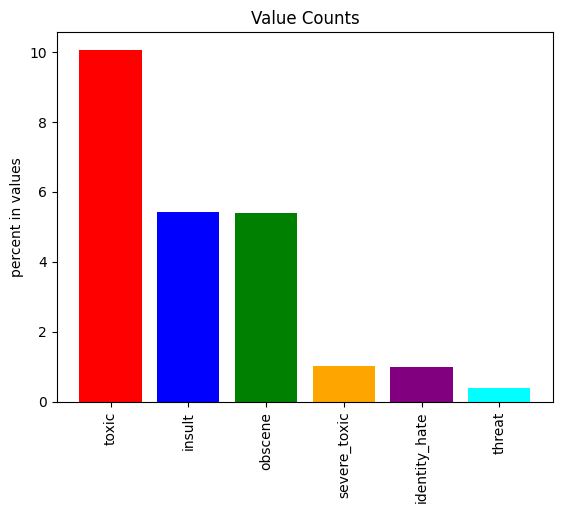

In [44]:
# plotting data

colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan']
plt.bar(sorted_categories, sorted_values, color=colors)
plt.ylabel('percent in values')
plt.xticks(rotation=90)
plt.title('Value Counts')
plt.show()

## Text Preprocessing

In [45]:
# function for text preprocessing


def preprocess(q):
    q = str(q).lower().strip()

    # Remove links (URLs)
    q = re.sub(r'http\S+|www\S+|https\S+', '', q, flags=re.MULTILINE)

    # Remove unwanted symbols and characters, keeping only letters, numbers, and whitespace
    q = re.sub(r'[^\w\s]', '', q)

    # Remove specific characters
    q = q.replace('?', '')
    q = q.replace('=', '')
    q = q.replace('-', '')

    # Replace certain special characters with their string equivalents
    q = q.replace('%', '')
    q = q.replace('$', '')
    q = q.replace('₹', '')
    q = q.replace('@', '')

    # Remove extra spaces
    q = re.sub(r'\s+', ' ', q).strip()

    q = q.replace('[UNK]', '')
    q = re.sub(r'\d+', '',q)
    q = re.sub(r'(.)\1{2,}', r'\1', q)

    # Decontracting words
    contractions = { 
        "ain't": "am not",
        "aren't": "are not",
        "abt": "about",
        "can't": "can not",
        "can't've": "can not have",
        "cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "d' aww": "aww",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "i'd": "i would",
        "i'd've": "i would have",
        "i'll": "i will",
        "i'll've": "i will have",
        "i'm": "i am",
        "i've": "i have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so as",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "u": "you",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have",
    }

    q_decontracted = []

    for word in q.split():
        if word not in stop_words:
            if word in contractions:
                word = contractions[word]
            q_decontracted.append(word.strip())

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")

    # Remove all punctuations
    q = re.sub(r'[^\w\s]', '', q)

    # Filter out non-English text
    # lang, _ = langid.classify(q)
    # if lang != 'en':
    #     return ''  # or return None to exclude non-English text

    return q.strip()


In [46]:
# applying preprocessing function 

df['comment_text'] = df['comment_text'].apply(preprocess)

In [47]:
df['comment_text'].sample(2)

3200    hehe wonder georgian germanaustrian friedns re...
3389    could option dont see would needed since state...
Name: comment_text, dtype: object

In [48]:
# splitting into X and y

X = df['comment_text']
y = df[df.columns[2:]].values

In [49]:
# max number of features

MAX_FEATURES = 200000

In [50]:
# vectorizing text

vectorizer = TextVectorization(max_tokens=MAX_FEATURES, 
                               output_sequence_length=1800,
                               output_mode='int')

In [51]:
# training vectorizer on our own data

vectorizer.adapt(X.values)

In [52]:
# Create a function to apply TextVectorization on batches
def preprocess_text(X_batch, y_batch):
    X_batch = vectorizer(X_batch)
    return X_batch, y_batch

In [53]:
# Create your dataset pipeline
dataset = tf.data.Dataset.from_tensor_slices((X.values, y))  # Replace 'text_column'
dataset = dataset.cache()  # Cache dataset to improve loading speed
dataset = dataset.shuffle(320000)  # Adjust based on your dataset size
dataset = dataset.batch(32)  # Process data in batches
dataset = dataset.map(preprocess_text)  # Apply vectorization to each batch
dataset = dataset.prefetch(8)  # Prefetch batches for performance

In [54]:
data_len = len(dataset)

In [55]:
# splitting dataset into training, testing and validation 

train = dataset.take(int(data_len*0.7))
val = dataset.skip(int(data_len*0.7)).take(int(data_len*0.2))
test = dataset.skip(int(data_len*0.9)).take(int(data_len*0.1))

## Create Sequential Model

In [61]:
# importing libraries

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [62]:
# building an archetecture

model = Sequential()

model.add(Embedding(MAX_FEATURES+1, 100))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))


In [63]:
# summary

model.build(input_shape=(None, 1))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 1, 100)         │    20,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        34,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,109,162 (76.71 MB)

 Trainable params: 20,109,162 (76.71 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# compiling model

model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=['accuracy', Precision(), Recall()])

In [65]:
# training model

hist = model.fit(train, epochs=5, validation_data=val)

109/109 ━━━━━━━━━━━━━━━━━━━━ 41s 337ms/step - accuracy: 0.8218 - loss: 0.2922 - precision_2: 0.0476 - recall_2: 0.0139 - val_accuracy: 0.9899 - val_loss: 0.1240 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00


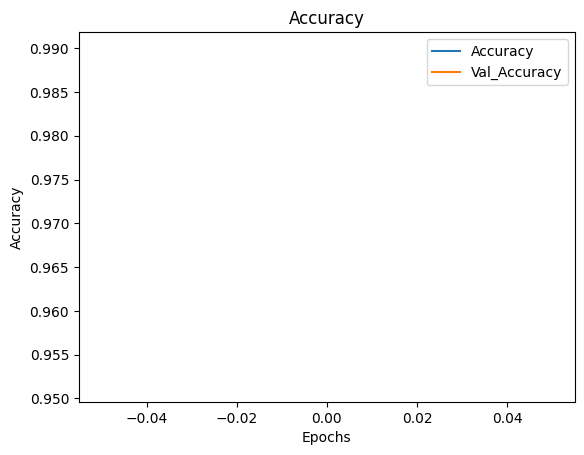

In [66]:
# plotting accuracy curve

plt.plot(hist.history['accuracy'], label='Accuracy')
plt.plot(hist.history['val_accuracy'], label='Val_Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

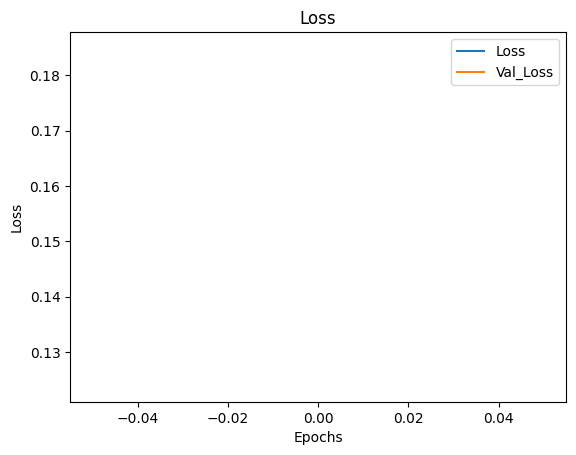

In [67]:
# plotting loss curve

plt.plot(hist.history['loss'], label='Loss')
plt.plot(hist.history['val_loss'], label='Val_Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
# testing model on user input

input_text = preprocess("You are a most idiot person I have ever seen")
input_text = vectorizer(input_text)

In [69]:
# making predictions on user input

model.predict(np.expand_dims(input_text, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step


array([[0.22985344, 0.03270918, 0.08002976, 0.01839232, 0.10561325,
        0.04147618]], dtype=float32)

In [70]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

## Model Evaluation

In [71]:
# testing data

test_batch_x, test_batch_y = test.as_numpy_iterator().next()

In [72]:
# precision, recall and accuracy of model 

pre = Precision()
rec = Recall()
acc = CategoricalAccuracy()

In [73]:
# calculating precision, recall and accuracy

for batch in test.as_numpy_iterator():
    X_true, y_true = batch
    y_hat = model.predict(X_true)

    y_true = y_true.flatten()
    y_hat = y_hat.flatten()

    pre.update_state(y_true, y_hat)
    rec.update_state(y_true, y_hat)
    acc.update_state(y_true, y_hat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


2024-09-26 02:13:47.695165: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [74]:
# printing accuracy

print(f'Precesion: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precesion: 0.0, Recall: 0.0, Accuracy: 0.2666666805744171


In [75]:
# saving models

model.save('toxic.h5')
model.save('toxic.keras')

In [76]:
# saving text vectorizer object for production

pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_vocabulary()}
            , open("models/tv_layer.pkl", "wb"))

In [77]:
vectorizer.get_vocabulary()

['',
 '[UNK]',
 'article',
 'page',
 'wikipedia',
 'would',
 'like',
 'talk',
 'one',
 'please',
 'dont',
 'ass',
 'see',
 'im',
 'also',
 'think',
 'know',
 'edit',
 'use',
 'people',
 'articles',
 'may',
 'time',
 'thanks',
 'get',
 'information',
 'even',
 'make',
 'good',
 'sources',
 'well',
 'could',
 'want',
 'deletion',
 'way',
 'fuck',
 'first',
 'name',
 'really',
 'made',
 'section',
 'new',
 'pages',
 'ive',
 'say',
 'need',
 'used',
 'much',
 'you',
 'go',
 'edits',
 'source',
 'right',
 'user',
 'said',
 'many',
 'find',
 'image',
 'help',
 'discussion',
 'thank',
 'since',
 'two',
 'editing',
 'still',
 'look',
 'read',
 'something',
 'someone',
 'link',
 'bot',
 'take',
 'work',
 'deleted',
 'fact',
 'editors',
 'going',
 'thats',
 'better',
 'back',
 'useless',
 'stop',
 'never',
 'history',
 'content',
 'case',
 'without',
 'utc',
 'sure',
 'point',
 'done',
 'block',
 'note',
 'youre',
 'personal',
 'might',
 'list',
 'us',
 'doesnt',
 'comment',
 'removed',
 'add',
